# A Look at the Rateable Valuation of Businesses in Ireland
## Author: Thomas Davis

In [1]:
# import modules we need
import os
import urllib.request
import csv
import pandas as pd
import json
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter
from datetime import date

### Task 1: Data Identification
The open web API which was chosen to be the data source was the valuation offices api. Every commercial property in Ireland has to pay rates to its local county council. The rates paid by a business are the "rateable valuation" by the "Annual Rate on Valuation (ARV)". The rateable valuation of a property is done by the Valuation office Ireland (www.valoff.ie), they make their valuation reports of properties in some county councils accessible by a REST api. This dataset is the subject of this assignment. It is interesting to see the distribution of comercial properties in Ireland and the difference in the average commercial property values between counties.

#### What does "Rateable Valuation" mean?
From the Valuation Office website, the rateable value is broadly speaking, the amount the owner of a commercial property would expect to receive if they leased their property for a year. To find this figure, the Valuation Office analyses rental transactions for all rateable properties.

### Task 2: Data Collection
This data was collected by making multiple api requests and appending the data to a big json file.

In [2]:
# function to make an api request and write it to a json file
def writeDataToFile(url, file):
    try:
        response = urllib.request.urlopen(link)
        data = json.loads(response.read())
        with open(file, 'a') as outfile:
            json.dump(data, outfile, indent=2, allow_nan=False)
        
        outfile.close()
        return True
    except urllib.error.HTTPError:
        #print("\n\n***Got HTTP error***\n\n")
        return False

In [3]:
# constants for api requests
website = "https://api.valoff.ie/api/Property/GetProperties?"
fileType = "Format=json&Download=false"

# a list of the possible data fields the api provides
possibleFields = ["LocalAuthority","Category","Level","AreaPerFloor","NavTotal",\
          "RateableValuation","CarPark","PropertyNumber","Use","FloorUse",\
          "Address","PublicationDate","ITM"];

# a list of business categories the api provides
categories = ["OFFICE","FUEL/DEPOT","LEISURE","INDUSTRIAL USES",\
             "HEALTH","HOSPITALITY","MINERALS","MISCELLANEOUS",\
              "RETAIL (SHOPS)","NO CATEGORY SELECTED","UTILITY",\
              "RETAIL (WAREHOUSE)","CENTRAL VALUATION LIST",\
             "CHECK CATEGORY","NON-LIST","NON-LIST EXEMPT"]

# a list of local authorities in the data set
localAuthorities = ["CARLOW COUNTY COUNCIL","CAVAN COUNTY COUNCIL",\
                   "DUBLIN CITY COUNCIL", "DUN LAOGHAIRE RATHDOWN CO CO",\
                   "FINGAL COUNTY COUNCIL","SOUTH DUBLIN COUNTY COUNCIL",\
                   "KILDARE COUNTY COUNCIL","KILKENNY COUNTY COUNCIL",\
                    "LAOIS COUNTY COUNCIL","LEITRIM COUNTY COUNCIL",\
                    "LIMERICK CITY AND COUNTY COUNCIL","LONGFORD COUNTY COUNCIL"\
                    ,"LOUTH COUNTY COUNCIL","MEATH COUNTY COUNCIL",\
                    "MONAGHAN COUNTY COUNCIL","OFFALY COUNTY COUNCIL",\
                    "ROSCOMMON COUNTY COUNCIL","SLIGO COUNTY COUNCIL",\
                    "TIPPERARY COUNTY COUNCIL","WATERFORD CITY AND COUNTY COUNCIL",\
                    "WESTMEATH COUNTY COUNCIL","WEXFORD COUNTY COUNCIL",\
                    "WICKLOW COUNTY COUNCIL"]

# these are the fields we want to retreive from the api
chosenFields = ["LocalAuthority","Category","RateableValuation",\
                "Use","PublicationDate"];

# join the fields with the url equivalent of a comma and add a prefix
chosenFieldsStr = "Fields=" + "%2C".join(chosenFields)


In [4]:
# the file to write the data to
dataName = "IrishBusinessesValuation"
today_date = date.today().strftime("_%d_%m_%Y")
json_data_file_raw = dataName+today_date+'.json'

In [5]:
failedRequestsLa = []
failedRequestsCat = []
# loop through all the local authorities and categories, make a request for each of them
# and then store the result in a json file
for la in localAuthorities:
    # local authority with space removed for url request
    lasr = la.replace(" ","%20")
    locAuth = "&LocalAuthority=" + lasr
    
    for category in categories:
        # category with space removed for url request
        categorySR = category.replace(" ","%20")
        categ = "&CategorySelected="+categorySR+"&"
        link = website+chosenFieldsStr+locAuth+categ+fileType
        
        #print("About to request: ",link)
        
        success = writeDataToFile(link, json_data_file_raw)
        
        if not success:
            failedRequestsLa.append(la)
            failedRequestsCat.append(category)


In [6]:
if (len(failedRequestsLa)!=0):
    for i in range(len(failedRequestsLa)):
        print("Failed Request in Local Authority ", failedRequestsLa[i], ", for the category ", failedRequestsCat[i])

Failed Request in Local Authority  CAVAN COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  KILDARE COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  KILKENNY COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  LIMERICK CITY AND COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  LOUTH COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  MEATH COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  ROSCOMMON COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  SLIGO COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  TIPPERARY COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  WEXFORD COUNTY COUNCIL , for the category  NON-LIST
Failed Request in Local Authority  WICKLOW COUNTY COUNCIL , for the category  NON-LIST


### Task 3: Data Preparation
There are a number of problems with the data in its current form which make it difficult to load into a pandas data frame. A number of steps need to be taken to clean the data and load it into a pandas data frame.

In [2]:
# run from here if you don't want to make api calls and raw file is in folder (make sure first cell has been run too)
json_data_file_raw = "IrishBusinessesValuation_23_03_2020.json"
json_data_file = "IrishBusinessesValuation.json"

In [3]:
# here we want to combine the all the requests into one big json file
# read the lines in
i=0
with open(json_data_file_raw, "r") as f:
    lines = f.readlines()
    
# open the file
with open(json_data_file, "w") as f:
    for line in lines:
        i= i+1
        # take away all the lines with just square brackets as they break up the json data sets
        if not ("[" in line.strip() and "]" in line.strip() and not any(c not in "][" for c in line.strip())) and (line.strip("\n")!="  }"):
            f.write(line)
        # add commas after last entry
        elif (line.strip("\n")=="  }"):
            f.write("  },\n")

In [4]:
# take valuation report from entries since there is no information in it
write = True
i=0
with open(json_data_file, "r") as f:
    lines = f.readlines()
with open(json_data_file, "w") as f:
    for line in lines:
        # delete lines after uses, if valuation report is the next line
        if ("Uses" in line and "ValuationReport" in lines[i+1]):
            write=False
            f.write(line[:-2]+"\n")
        if write:
            f.write(line)
        # start writing the lines again if the valuation report has ended marked by ]
        if ("]" in line and not "Uses" in line):
            write=True
        i= i + 1

In [5]:
# remove comma from final entry and add final square bracket if its not there (can be removed by previous code)
with open(json_data_file, "r") as f:
    lines = f.readlines()
# get number of lines in file
ln = len(lines)

# if the last line isn't a square bracket, indicate that and delete comma at end of line
if (not "]" in lines[ln-1]):
    print("Not there, line: ",ln-1)
    lines[ln-1] = lines[ln-1][:-2]+"\n"
    hasEnd = False
# if the last line is a square bracket, delete comma on second last line
else:
    lines[ln-2] = lines[ln-2][:-2]+"\n"
    hasEnd = True
# write the lines back into the file
with open(json_data_file, "w") as f:
    for line in lines:
        f.write(line)
    # if square bracket was not there, add it in
    if not hasEnd:
        f.write("]")

Not there, line:  2478704


In [6]:
# there are some null values json has a problem with, get rid of them or set a default date
with open(json_data_file, "r") as f:
    lines = f.readlines()
with open(json_data_file, "w") as f:
    for line in lines:
        line = line.replace("NaN","0.0")
        line = line.replace("nan","0.0")
        line = line.replace("None","\"01/01/1900\"")
        line = line.replace("null","\"01/01/1900\"")
        f.write(line)
f.close()

In [7]:
# read the data into a pandas data frame
with open(json_data_file, "r") as json_file:
    json_data = json.load(json_file)
json_file.close()
# need to format so pandas can read
json_data = str(json_data)
json_data = json_data.replace("'", "\"")
df = pd.read_json(json_data,orient='records',dtype=True, lines=False,precise_float=True, chunksize=None)

# show some data
df[0:10]

PublicationDate  County         LocalAuthority  Valuation Category  \
0      15/09/2017  CARLOW  CARLOW COUNTY COUNCIL     9810.0   OFFICE   
1      15/10/2019  CARLOW  CARLOW COUNTY COUNCIL        0.0   OFFICE   
2      15/09/2017  CARLOW  CARLOW COUNTY COUNCIL     1900.0   OFFICE   
3      28/01/2019  CARLOW  CARLOW COUNTY COUNCIL    12940.0   OFFICE   
4      15/11/2019  CARLOW  CARLOW COUNTY COUNCIL     3790.0   OFFICE   
5      11/01/2019  CARLOW  CARLOW COUNTY COUNCIL     3000.0   OFFICE   
6      05/07/2019  CARLOW  CARLOW COUNTY COUNCIL     4160.0   OFFICE   
7      18/11/2019  CARLOW  CARLOW COUNTY COUNCIL     3060.0   OFFICE   
8      07/11/2019  CARLOW  CARLOW COUNTY COUNCIL     1350.0   OFFICE   
9      05/07/2019  CARLOW  CARLOW COUNTY COUNCIL     4570.0   OFFICE   

                         Uses  
0  OFFICE (1ST GENERATION), -  
1  OFFICE (1ST GENERATION), -  
2        OFFICE (OWN DOOR), -  
3        OFFICE (OWN DOOR), -  
4        OFFICE (OWN DOOR), -  
5        OFFICE (OWN DOOR), -  
6  OFFICE (1ST GENERATION), -  
7  OFFICE (INDUSTRIAL), STORE  
8                   STUDIO, -  
9  OFFICE (1ST GENERATION), -

In [8]:
df["PublicationDate"] = pd.to_datetime(df["PublicationDate"])

In [9]:
df = df[df.Valuation != 0.0] # get rid of the rows with a zero valuation

In [10]:
df.describe()

Valuation
count  1.016510e+05
mean   5.397045e+04
std    6.618199e+05
min    6.000000e-02
25%    5.680000e+03
50%    1.197000e+04
75%    2.760000e+04
max    1.548970e+08

### Task 4: Data Analysis
Now the that the data is loaded, we can examine it for interesting insights.
The maximum rated property in the data is Dublin Airport which is rateable valuation of just under 155 million.

In [11]:
df.loc[df['Valuation'].idxmax()] # find the max 

PublicationDate      2019-09-17 00:00:00
County                            DUBLIN
LocalAuthority     FINGAL COUNTY COUNCIL
Valuation                    1.54897e+08
Category                         UTILITY
Uses                   AIRPORT, TERMINAL
Name: 60047, dtype: object

First we plot the distribution of the different rateable valuations.

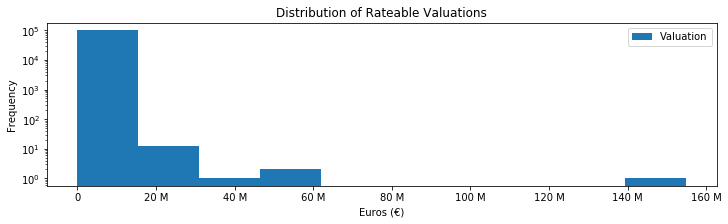

In [40]:
ax = df[["Valuation"]].plot.hist(by="Valuation",log=True,title="Distribution of Rateable Valuations")
ax.set_xlabel("Euros (€)")
formatter0 = EngFormatter(unit='')
ax.xaxis.set_major_formatter(formatter0)

The histogram is clearly skewed by the Airport, if we only consider properties up to a rateable value of 30 thousand, a better picture emerges.

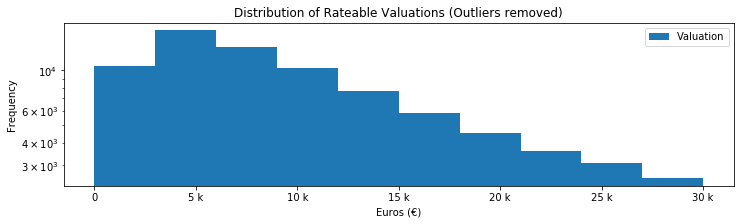

In [41]:
ax = df[["Valuation"]].plot.hist(by="Valuation",log=True, range=(0,30e3), title="Distribution of Rateable Valuations (Outliers removed)")
ax.set_xlabel("Euros (€)")
formatter0 = EngFormatter(unit='')
ax.xaxis.set_major_formatter(formatter0)

It can be observed in this distribution (which removes properties with a rateable value greater than 30 thousand) that the vast majority of commercial properties have a rateable valuation of less than 5 thousand. We see that the distribution looks somewhat like a log curve. To check if the distribution is "lognormal" a distribution seen often in human behaviours (e.g. the length of internet forum posts https://rdcu.be/b3a7e). To test this, we take the logarithmic of the valuations and plot the distribution again.

In [42]:
df_log = df
df_log["Log Valuation"] = np.log(df_log["Valuation"])
df_log = df_log.drop(columns=["Valuation"])

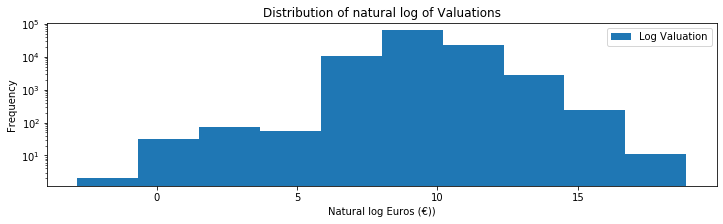

In [43]:
ax = df_log[["Log Valuation"]].plot.hist(by="Log Valuation", log=True, title="Distribution of natural log of Valuations")
ax.set_xlabel("Natural log Euros (€))")
formatter0 = EngFormatter(unit='')
ax.xaxis.set_major_formatter(formatter0)

This data looks a lot more normal, although possbily somewhat skewed to the right. Further tests could be carried out to test the statistical significance of this hypothesis but for now we'll tentatively assume the rateable valuation of commercial properties is somewhat "lognormal".

Next we consider the data at a county level.

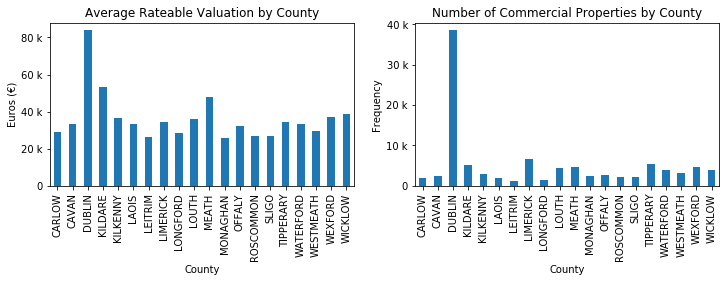

In [44]:
matplotlib.rcParams['figure.figsize'] = [12, 3]
fig, axs = plt.subplots(1,2)
df.groupby(["County"])["Valuation"].mean().plot.bar(ax=axs[0])
df.groupby(["County"])["Valuation"].count().plot.bar(ax=axs[1])
axs[0].set_ylabel("Euros (€)")
axs[1].set_ylabel("Frequency")
axs[0].set_title("Average Rateable Valuation by County")
axs[1].set_title("Number of Commercial Properties by County")
axs[0].yaxis.set_major_formatter(formatter0)
axs[1].yaxis.set_major_formatter(formatter0)
plt.show()

When the we examine the average valuation by county, we observe that businesses in Dublin are clearly a lot higher than elsewhere in the country, with the average valuation being over 80 thousand, while the next highest counties are Kildare and Meath, which are partly in the "Greater Dublin Area", big companies such as Intel, HP among others locate in these regions just outside Dublin, since they are close to the city but far enough away so they can locate massive factories. The average valuation is higher than even other counties with cities like Limerick, Waterford and Kilkenny. 
The number of commercial properties also highlights Dublin's dominance of commerce in Ireland. Dublin has more than four times as many commercial properties than the next highest county. Besides Dulin, small rural counties such as Carlow and Leitrim have the least amount of commercial properties while cities such as Limerick and large counties such as Tipperary have the highest number.

Next we consider the data by the category of the property.

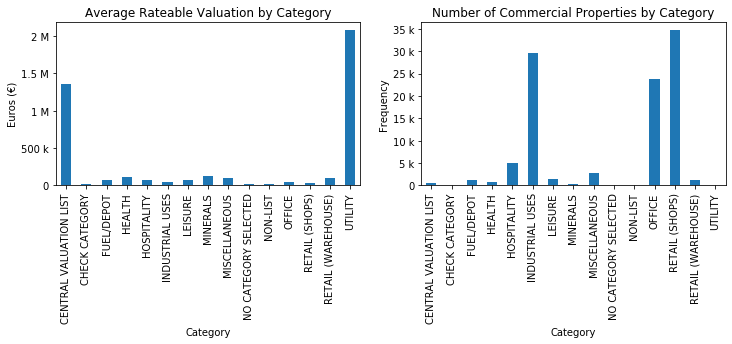

In [22]:
fig, axs = plt.subplots(1,2)
df.groupby(["Category"])["Valuation"].mean().plot.bar(ax=axs[0])
df.groupby(["Category"])["Valuation"].count().plot.bar(ax=axs[1])
axs[0].set_ylabel("Euros (€)")
axs[1].set_ylabel("Frequency")
axs[0].set_title("Average Rateable Valuation by Category")
axs[1].set_title("Number of Commercial Properties by Category")
axs[0].yaxis.set_major_formatter(formatter0)
axs[1].yaxis.set_major_formatter(formatter0)
plt.show()

For the average rateable valuations, the "Utilities and the "Cental Valuation List" dwarf any other category, this is since both these categories contain Public Utilities which often mean they contain large infastructure properties such as power stations and water treatment facilities, we will take these categories out to analyse the others further.
The categories with the most properties are offices, shops and industrial sites, meanwhile, there are very few utilites and central valuation items, which makes sense.

In [23]:
# remove two outlier categories
indexNames = df[ df['Category'] == "CENTRAL VALUATION LIST"].index
indexNames = indexNames.append(df[ df['Category'] == "UTILITY"].index)
dfNoUtil_CVL = df.drop(indexNames)

Text(0.5, 1.0, 'Average Rateable Value by Category')

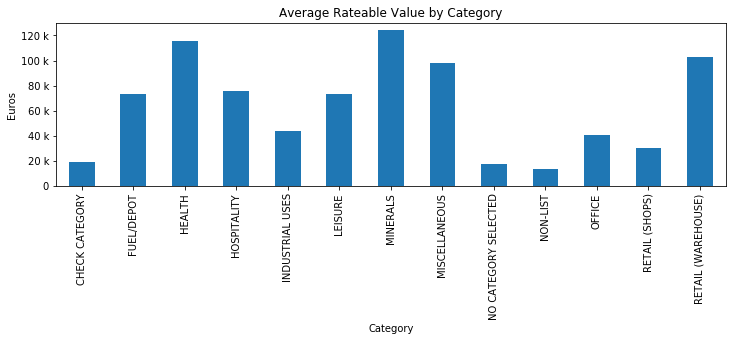

In [27]:
ax = dfNoUtil_CVL.groupby(["Category"])["Valuation"].mean().plot.bar()
ax.set_ylabel("Euros")
ax.yaxis.set_major_formatter(formatter0)
ax.set_title("Average Rateable Value by Category")

Without the outliers the Minerals category (mines and quarries) are the most valuable, followed by health-care properties (hospitals, GP practices, dentists etc.). Shops and offices tend to be the least valuable properties.

The final metric we consider is the value of commercial properties over time. We only want to consider three different categories, offices, shops and indutrial sites since they are the are the most numerous and their average value is similar. This will remove outliers like big public utilities like airports and such. A scatter plot of the data (negating the entries before 2012) is plotted. 

Text(0.5, 1.0, 'Scatter plot Valuation vs. Time')

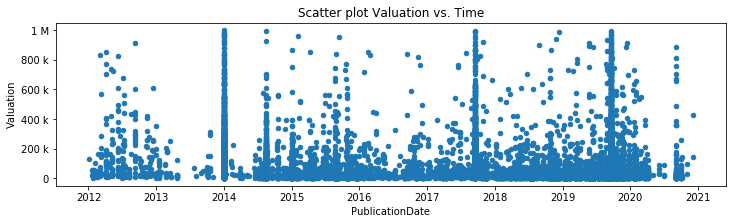

In [28]:
indexNames = df[ (df['PublicationDate'] < pd.Timestamp('2012-01-01')) | (df['Valuation'] > 1e6)].index
#print(len(indexNames))
indexNames = indexNames.append(df[ (df["Category"] != "OFFICE") & (df["Category"] != "RETAIL (SHOPS)") & (df["Category"] != "INDUSTRIAL USES")].index)
#print(len(indexNames))
df_ORI = df.drop(indexNames)
ax = df_ORI.plot.scatter(x="PublicationDate", y="Valuation")
ax.yaxis.set_major_formatter(formatter0)
ax.set_title("Scatter plot Valuation vs. Time")

We want to plot the average value of commercial properties each year, we can see that there is only sufficient data to get a good average in 2012 so we choose a range of 2012-2019 to plot the average commercial properties.

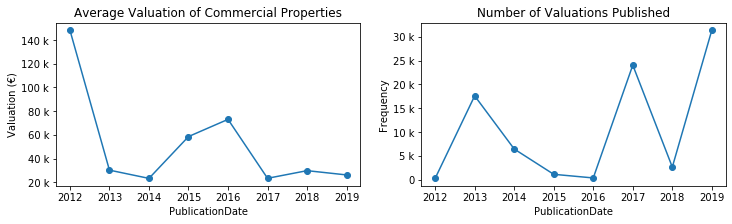

In [29]:
yearly = df_ORI[ (df_ORI['PublicationDate'] > pd.Timestamp('2012-01-01')) & (df_ORI['PublicationDate'] < pd.Timestamp('2020-01-01')) ].groupby(df_ORI.PublicationDate.dt.year)
avg_year = yearly["Valuation"].mean() #create a new DF based on the mean of the groupby object created above
num_year = yearly.count()
fig, axs = plt.subplots(1,2)
avg_year.plot(style="-o", ax=axs[0])
num_year["Valuation"].plot(style="-o", ax=axs[1])
axs[0].set_title("Average Valuation of Commercial Properties")
axs[1].set_title("Number of Valuations Published")
axs[1].set_ylabel("Frequency")
axs[0].set_ylabel("Valuation (€)")
axs[0].yaxis.set_major_formatter(formatter0)
axs[1].yaxis.set_major_formatter(formatter0)

There is no clear commercial property valuation trend over time, the average valuation of was highest in 2012 and then spikes again in 2016. The number of valuation reports also varies a lot from year to year which could be affecting the consistancy of the yearly average. Another factor could be that in one year, many properties may be re-valued in one county, biasing the average of that year.

## Conclusion
To conclude, we have gained some interesting insights by examining the Valuation Office's dataset. We learned about the distribution of comercial property values, approximately lognormal. That dublin airport is the most valuable commercial property in the dataset (most likely in Ireland too). We learned of the dominance of Dublin in terms of number and value of business vs. the rest of the counties in the dataset. The number and value of different categories of commercial properties, shops being the most common and utilities being the most valuable. This was an interesting look into the rateable value of commercial properties in Ireland.